# Chapter 4: Training Linear Models

### Ensure GPU environment is setup

In [1]:
import tensorflow as tf
from tensorflow import keras 

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
tf.test.is_built_with_cuda()

True

In [4]:
print(tf.version.VERSION)

2.1.0


In [5]:
import sys
import os
sys.version

'3.6.13 |Anaconda, Inc.| (default, Mar 16 2021, 11:37:27) [MSC v.1916 64 bit (AMD64)]'

## Linear Regression

### Creating the Normal Equation 

In [6]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

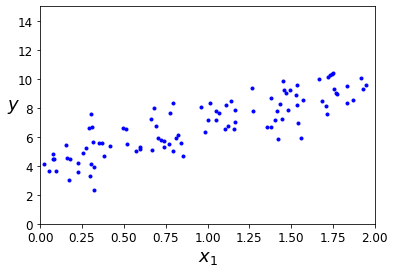

In [7]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

In [8]:
X_b = np.c_[np.ones((100, 1)), X] # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [9]:
theta_best

array([[4.0718098 ],
       [2.85763335]])

In [10]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new] # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.0718098],
       [9.7870765]])

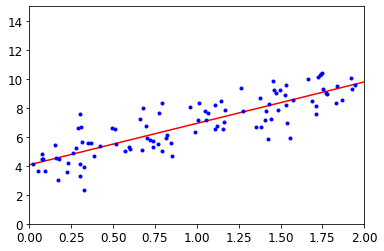

In [11]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

In [12]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.0718098]), array([[2.85763335]]))

In [13]:
lin_reg.predict(X_new)

array([[4.0718098],
       [9.7870765]])

In [14]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.0718098 ],
       [2.85763335]])

In [15]:
np.linalg.pinv(X_b).dot(y)

array([[4.0718098 ],
       [2.85763335]])

## Gradient Descent

### Batch Gradient Descent

In [16]:
# Gradient Descent Implementation
eta = 0.1 # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1) # random initialization

for iteration in range(n_iterations):
 gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
 theta = theta - eta * gradients


In [17]:
theta

array([[4.0718098 ],
       [2.85763335]])

In [18]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

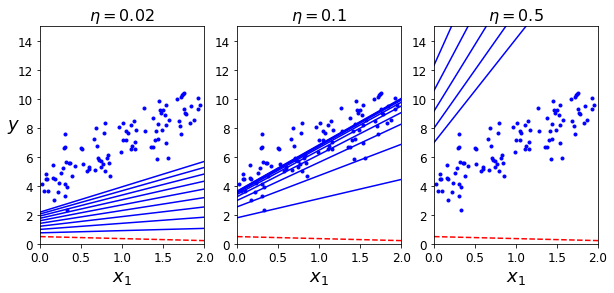

In [19]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

plt.show()

## Stochastic Gradient Descent 

In [20]:
theta_path_sgd = []
m = len(X_b)

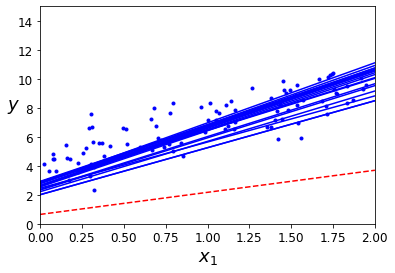

In [21]:
# Stochastic Gradient Descent implementation
n_epochs = 50
t0, t1 = 5, 50 # learning schedule hyperparameters
def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1) # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    
            y_predict = X_new_b.dot(theta)           
            style = "b-" if i > 0 else "r--"         
            plt.plot(X_new, y_predict, style)        
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)                 

plt.plot(X, y, "b.")                                 
plt.xlabel("$x_1$", fontsize=18)                     
plt.ylabel("$y$", rotation=0, fontsize=18)           
plt.axis([0, 2, 0, 15])                                                               
plt.show()                                           

In [22]:
theta

array([[4.11258534],
       [2.85684013]])

In [23]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [24]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.09610073]), array([2.90619277]))

## Mini-Batch Gradient Descent

In [25]:
# Mini-batch gradient descent 
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [26]:
theta

array([[4.09027812],
       [2.90507961]])

In [27]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

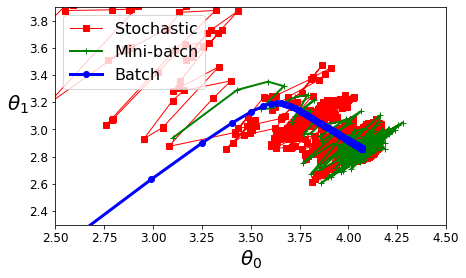

In [28]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()

## Polynomial Regression

In [29]:
# Polynomial Regression 
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

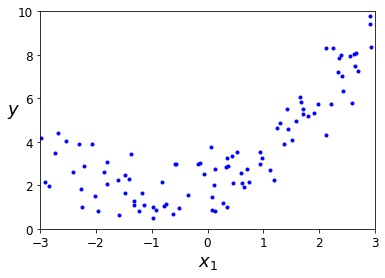

In [30]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

In [31]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
print(X[0])
print(X_poly[0])

[2.38942838]
[2.38942838 5.709368  ]


In [32]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.9735233]), array([[0.95038538, 0.52577032]]))

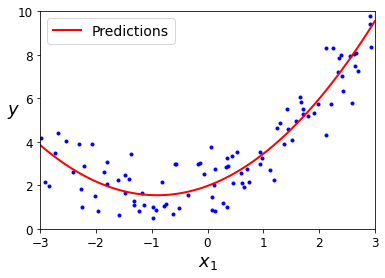

In [33]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

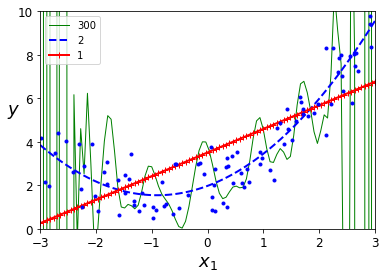

In [34]:
# Learning Curves 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

## Learning Curves

In [35]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)              


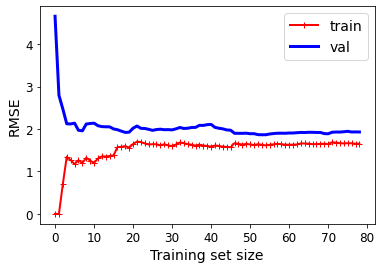

In [36]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

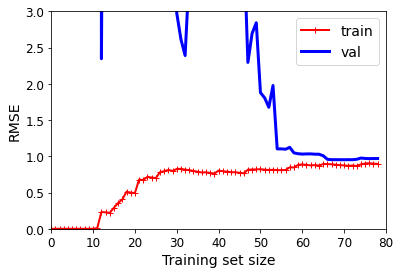

In [37]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])             
plt.show()                        

## Regularized Linear Models 

### Ridge Regression

In [38]:
# Ridge Regression 
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

In [39]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.56411184]])

In [40]:
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.56377563]])

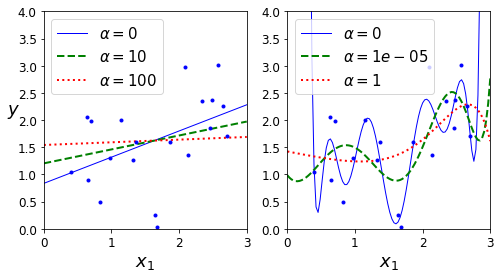

In [41]:
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

plt.show()

## Lasso Regression

D:\Anaconda\envs\GPUenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6534258693999493, tolerance: 0.0012500531184305643
  positive)


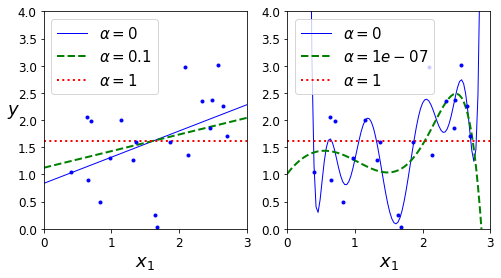

In [42]:
#Lasso Regression 
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

plt.show()

In [43]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.58211786])

## Elastic Net

In [44]:
#Elastic Net
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.57473993])

## Early Stopping

In [45]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [46]:
from copy import deepcopy

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

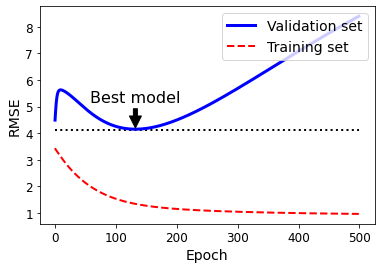

In [47]:
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.show()

## Logistic Regression

### Decision Boundaries

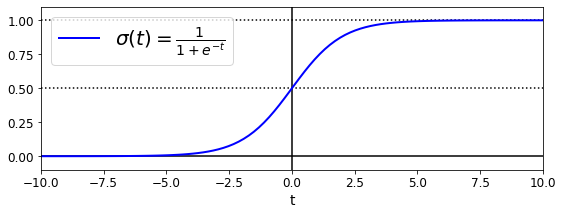

In [48]:
#Logistic Regression 
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
plt.show()

In [49]:
from sklearn import datasets
iris = datasets.load_iris()
print(list(iris.keys()))
X = iris["data"][:, 3:] # petal width
y = (iris["target"] == 2).astype(np.int) # 1 if Iris virginica, else 0

['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename']


In [50]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

D:\Anaconda\envs\GPUenv\lib\site-packages\matplotlib\patches.py:1338: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  verts = np.dot(coords, M) + (x + dx, y + dy)


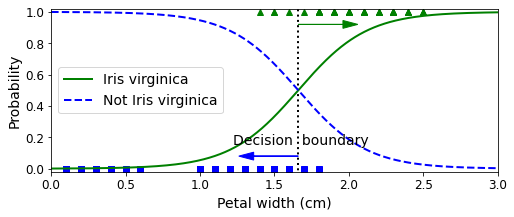

In [53]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
plt.show()

In [54]:
log_reg.predict([[1.7], [1.5]])


array([1, 0])

## Softmax Regression

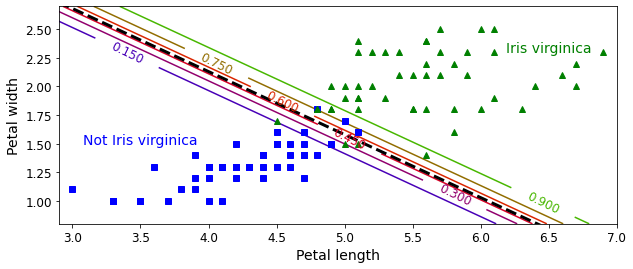

In [55]:
# Softmax Regression
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
plt.show()

In [56]:
X = iris["data"][:, (2, 3)] # petal length, petal width
y = iris["target"]
softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10)
softmax_reg.fit(X, y)


LogisticRegression(C=10, multi_class='multinomial')

In [57]:
softmax_reg.predict([[5, 2]])

array([2])

In [58]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

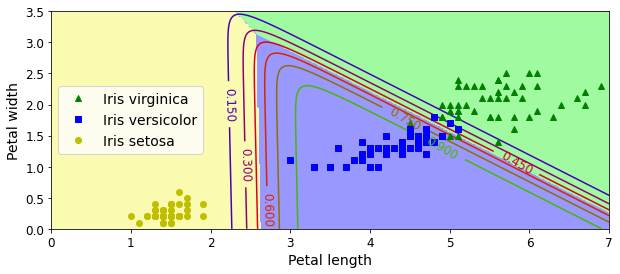

In [59]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

## End of Chapter Questions

**1. Which Linear Regression training algorithm can you use if you have a training
set with millions of features?**

**2. Suppose the features in your training set have very different scales. Which algo‐
rithms might suffer from this, and how? What can you do about it?**

**3. Can Gradient Descent get stuck in a local minimum when training a Logistic
Regression model?**

**4. Do all Gradient Descent algorithms lead to the same model, provided you let
them run long enough?**

**5. Suppose you use Batch Gradient Descent and you plot the validation error at
every epoch. If you notice that the validation error consistently goes up, what is
likely going on? How can you fix this?**

**6. Is it a good idea to stop Mini-batch Gradient Descent immediately when the vali‐
dation error goes up?**

**7. Which Gradient Descent algorithm (among those we discussed) will reach the
vicinity of the optimal solution the fastest? Which will actually converge? How
can you make the others converge as well?**

**8. Suppose you are using Polynomial Regression. You plot the learning curves and
you notice that there is a large gap between the training error and the validation
error. What is happening? What are three ways to solve this?**

**9. Suppose you are using Ridge Regression and you notice that the training error
and the validation error are almost equal and fairly high. Would you say that the
model suffers from high bias or high variance? Should you increase the regulari‐
zation hyperparameter α or reduce it?**

**10. Why would you want to use:
a. Ridge Regression instead of plain Linear Regression (i.e., without any regula‐
rization)?
b. Lasso instead of Ridge Regression?
c. Elastic Net instead of Lasso?**

**11. Suppose you want to classify pictures as outdoor/indoor and daytime/nighttime.
Should you implement two Logistic Regression classifiers or one Softmax Regression classifier?**

**12. Implement Batch Gradient Descent with early stopping for Softmax Regression
(without using Scikit-Learn).**

**1. Which Linear Regression training algorithm can you use if you have a training
set with millions of features?**

A: Stochastic Gradient Descent can be used as a Linear Regression training algorithm for datasets with many features.

**2. Suppose the features in your training set have very different scales. Which algo‐
rithms might suffer from this, and how? What can you do about it?**

A: Ridge Regression will suffer greatly from this. Because ridge regression uses a regularization term on the data, it already regularizes the data. If the data is not scaled properly, The independent variables will suffer as a result and alpha will be vary greatly between these variables. One way to deal with this is to scale the data before performing ridge regression.

**3. Can Gradient Descent get stuck in a local minimum when training a Logistic
Regression model?**

A: No, because the cost function (log loss function) is convex, gradient descent will find the gloabl minimum as long as the learning rate is too large and sufficient time resources are used. 

**4. Do all Gradient Descent algorithms lead to the same model, provided you let
them run long enough?**

A: No. There was a very good example in the textbook showing differences between different model parameters graphically. Notably with Stochastic Gradient Descent. Although it is quite fast, it will typically bounce around near the minimum but never stop at an optimal solution (This is also similar with batch gradient descent).

**5. Suppose you use Batch Gradient Descent and you plot the validation error at
every epoch. If you notice that the validation error consistently goes up, what is
likely going on? How can you fix this?**

A: This is usually a result of the learning rate being too high and the model diverges from the original solution getting further and further away from the solution at each step, resulting in an increase validation error. One way to fix this is start will a very small learning rate and maybe even test a few different learning rates or using grid search to assist with this. 

**6. Is it a good idea to stop Mini-batch Gradient Descent immediately when the vali‐
dation error goes up?**

A: That will depend. Although Mini-batch gradient descent is must faster than say the standard SVD linear regression method, it also has the similar problem as stochastic GD where it bounces around the minimum. So depending how far along it has trained it may not be ideal. This is due to it bouncing around and may increase from an amount very close to the minimum to something a little bit farther away. 

**7. Which Gradient Descent algorithm (among those we discussed) will reach the
vicinity of the optimal solution the fastest? Which will actually converge? How
can you make the others converge as well?**

A: Mini-batch GD is the least erratic of the 5 algorithms discussed but it most likely will not be optimal, just in the vicinity. The one that is fastest that will converge will most likely be Batch GD. Using regularization parameters may help or regularization techiniques such as Ridge Regression or Lasso Regression. 

**8. Suppose you are using Polynomial Regression. You plot the learning curves and
you notice that there is a large gap between the training error and the validation
error. What is happening? What are three ways to solve this?**

A: Most likely the training model was overfit resulting high variance (from bias/variance trade-off) which is resulting in the error discrepency. 
3 ways to solve:
1. Larger training dataset
2. Regularize the model using Lasso or Ridge Regression
3. Smaller degress of freedom

**9. Suppose you are using Ridge Regression and you notice that the training error
and the validation error are almost equal and fairly high. Would you say that the
model suffers from high bias or high variance? Should you increase the regulari‐
zation hyperparameter α or reduce it?**

A: If the model tends to perform better on training data than on the validation data, this is most likely high variance and overfitting. If they are both high, the model may have been fit wrong part of a generalization error resulting in a badly fit model on the data. So that is most likely, but there also may be irredicuble error that is high. This can be fixed by cleaning up the data (ex. removing outlers, feature engineering, etc.). In this case, we should reduce the regularization hyperparameter which will help flatten the predictions, but because of this bias will increase. 

**10. Why would you want to use:
a. Ridge Regression instead of plain Linear Regression (i.e., without any regula‐
rization)?
b. Lasso instead of Ridge Regression?
c. Elastic Net instead of Lasso?**

A: a) Ridge Regression is a regularized version of Linear Regression, so it will help the process of gradient descent with the cost function associated and helps keep the model weights small. 

b) Lasso would work better if you wanted to help with eliminating the least important features in your data and lasso automatically performs feature selection. The gradients in Lasso also get small as you approach the global min, so it helps with convergence to the optimal solution. 

c) Elastic net is a middle ground between ridge and lasso. The benefit that elastic net would have over lasso is if several features are strongly correlated. As a result, Elastic Net may may behave erratically as a result and have more difficulty converging to an optimal solution. 

**11. Suppose you want to classify pictures as outdoor/indoor and daytime/nighttime.
Should you implement two Logistic Regression classifiers or one Softmax Regression classifier?**

A: You could do two different logistic regression classifiers and that could work. One would look for pictures that have an outdoor or indoor setting and then the other would be for daytime/nighttime. 

**12. Implement Batch Gradient Descent with early stopping for Softmax Regression
(without using Scikit-Learn).**

A: Next Cell:

In [2]:
#Using Iris Dataset 
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

Load data and add bias term: ($x_0 = 1$)

In [12]:
import numpy as np
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

X_with_bias = np.c_[np.ones([len(X), 1]), X]

In [26]:
# Split data into training, validation, testing sets
test_split = 0.2
validation_split = 0.2
total_size = len(X_with_bias)

test_size = int(total_size*test_split)
validation_size = int(total_size*validation_split)
train_size = total_size - test_size - validation_size

random_indices = np.random.permutation(total_size)

X_train = X_with_bias[random_indices[:train_size]]
y_train = y[random_indices[:train_size]]
X_validation = X_with_bias[random_indices[train_size:-test_size]]
y_validation = y[random_indices[train_size:-test_size]]
X_test = X_with_bias[random_indices[-test_size:]]
y_test = y[random_indices[-test_size:]]

In [27]:
def one_hot_encoding(y):
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot

In [33]:
y_train[:10]

array([1, 2, 2, 0, 2, 2, 2, 2, 1, 0])

In [35]:
one_hot_encoding(y_train[:10])

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [36]:
Y_train_one_hot = one_hot_encoding(y_train)
Y_valid_one_hot = one_hot_encoding(y_validation)
Y_test_one_hot = one_hot_encoding(y_test)

In [37]:
print(Y_train_one_hot)

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0.

Softmax Function: $\sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}$

In [38]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

In [41]:
n_inputs = X_train.shape[1]
n_outputs = len(np.unique(y_train))

Cost function equation: 

$J(\mathbf{\Theta})$ = $\dfrac{1}{m}\sum\limits{i=1}^{m}\sum\limits{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}$


Gradient Equation: 

$\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}$

In [42]:
eta = 0.01
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    if iteration % 500 == 0:
        loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
        print(iteration, loss)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error)
    Theta = Theta - eta * gradients

0 1.1801358488341387
500 0.5884551410700508
1000 0.5248167023274912
1500 0.48333026890818165
2000 0.4538930724517848
2500 0.43153723739621286
3000 0.41366571657075174
3500 0.3988227706479686
4000 0.38613785427253766
4500 0.37505998429397414
5000 0.3652229631113051


In [43]:
Theta

array([[ 4.28904556,  0.53806891, -2.5009082 ],
       [-1.15602757, -0.03386725, -0.41809524],
       [-2.30315952, -1.11646828,  1.9372866 ]])

In [46]:
logits = X_validation.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_validation)
accuracy_score

1.0

This means that our model was predicted perfectly... this seems unlikely. let us keep going:

In [47]:
# increase learning rate and add penalty function
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    if iteration % 500 == 0:
        xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
        l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
        loss = xentropy_loss + alpha * l2_loss
        print(iteration, loss)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 1.704959738922961
500 0.5462670677095975
1000 0.5219401029902032
1500 0.5141746846931776
2000 0.5112102521971428
2500 0.5099945493049574
3000 0.5094770482788851
3500 0.5092519363837988
4000 0.5091527022501663
4500 0.5091085869763776
5000 0.5090888677333304


Loss function is greater than before...

In [49]:
logits = X_validation.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_validation)
accuracy_score

1.0

No change in accuracy thus far... which makes sense

In [51]:
eta = 0.1 
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter
best_loss = np.infty

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

    logits = X_validation.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_valid_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    if iteration % 500 == 0:
        print(iteration, loss)
    if loss < best_loss:
        best_loss = loss
    else:
        print(iteration - 1, best_loss)
        print(iteration, loss, "early stopping!")
        break

0 3.759947124726559
500 0.496114499008648
1000 0.46563261091763963
1500 0.4573500366319962
2000 0.4545395192716243
2500 0.4535511068088399
3000 0.45322508883273727
3500 0.45314250265392814
3703 0.45313781541452347
3704 0.45313781541920906 early stopping!


In [52]:
logits = X_validation.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_validation)
accuracy_score

1.0

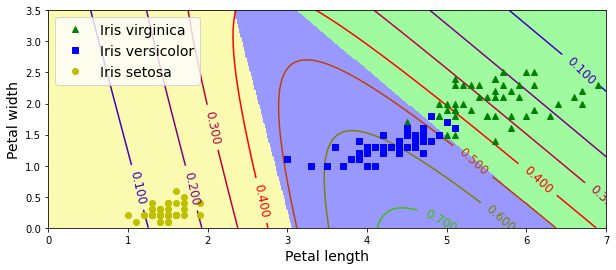

In [56]:
# Plot Grid 
import matplotlib as mlp
import matplotlib.pyplot as plt
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

logits = X_new_with_bias.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

In [57]:
logits = X_test.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

0.9666666666666667

Pretty good accuracy overall on the model as a whole. Good practice exercise